# Wine Reviews: Predicting price and points


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline


from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn import linear_model

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import xgboost as xgb
from xgboost import XGBRegressor

from statsmodels.tools.eval_measures import mse, rmse
import time
import math

# Plot formatting: 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'



In [5]:
features = pd.read_csv('wine_features.csv')
features.head()

,country,description,designation,points,price,province,region_1,variety,winery,origin,description_length,logprice
0,New Zealand,yields intensity giving medium bodied silky po...,mates vineyard,94,57.0,kumeu,None,chardonnay,Kumeu River,New Zealand: other,215,4.043051
1,US,standout rocks district brings earth shaking a...,the funk estate,94,60.0,washington,Walla Walla Valley (WA),syrah,Saviah,US: Washington,333,4.094345
2,Argentina,concentrated ripe blackberry cassis aromas com...,the apple doesnt fall far from the tree,91,30.0,mendoza province,Mendoza,malbec,Matias Riccitelli,Argentina: Mendoza Province,242,3.401197
3,Australia,moorooducs estate solid value among boutique o...,none,91,36.0,victoria,Mornington Peninsula,pinot noir,Moorooduc,Australia: Victoria,315,3.583519
4,Argentina,smoky aromas fresh cut wood berry cassis form ...,alegoria gran reserva,91,25.0,mendoza province,Mendoza,malbec,Navarro Correas,Argentina: Mendoza Province,229,3.218876


In [3]:
features2 = pd.read_csv('wine_features2.csv')
features2.head()

,points,price,description_length,0,1,2,3,4,5,6,...,90.1,91.1,92.1,93.1,94.1,95.1,96.1,97.1,98.1,99.1
0,94,57.0,215,0.116228,0.057323,0.001090,0.006004,-0.033671,-0.078709,0.074234,...,-0.000521,-0.012709,-0.003340,-0.012222,-0.007026,0.003120,-0.001188,-0.007964,-0.001961,-0.006254
1,94,60.0,333,0.094332,0.020973,0.049967,0.026527,-0.023274,-0.024780,0.017350,...,-0.000622,-0.002339,-0.000451,0.003082,0.000381,0.000816,-0.001791,0.000765,-0.007042,-0.002981
2,91,30.0,242,0.244494,-0.087650,0.125325,0.014462,0.051066,-0.100107,0.006066,...,0.003228,0.001011,0.000652,0.001203,-0.001679,-0.001839,0.011337,-0.006897,0.005649,0.002861
3,91,36.0,315,0.088699,-0.049204,0.038265,0.001421,-0.020274,0.003372,-0.004968,...,-0.030156,-0.000448,-0.011946,-0.011439,-0.011197,0.003599,0.002402,0.003211,-0.025017,-0.016360
4,91,25.0,229,0.218493,0.028884,0.152262,0.027505,0.007203,-0.046983,-0.079486,...,0.003228,0.001011,0.000652,0.001203,-0.001679,-0.001839,0.011337,-0.006897,0.005649,0.002861


In [44]:
features2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83942 entries, 0 to 83941
Columns: 1603 entries, points to 99.1
dtypes: float64(1601), int64(2)
memory usage: 1.0 GB


## Wine Price Regression Modeling:


Visualizing our target variable `price`:

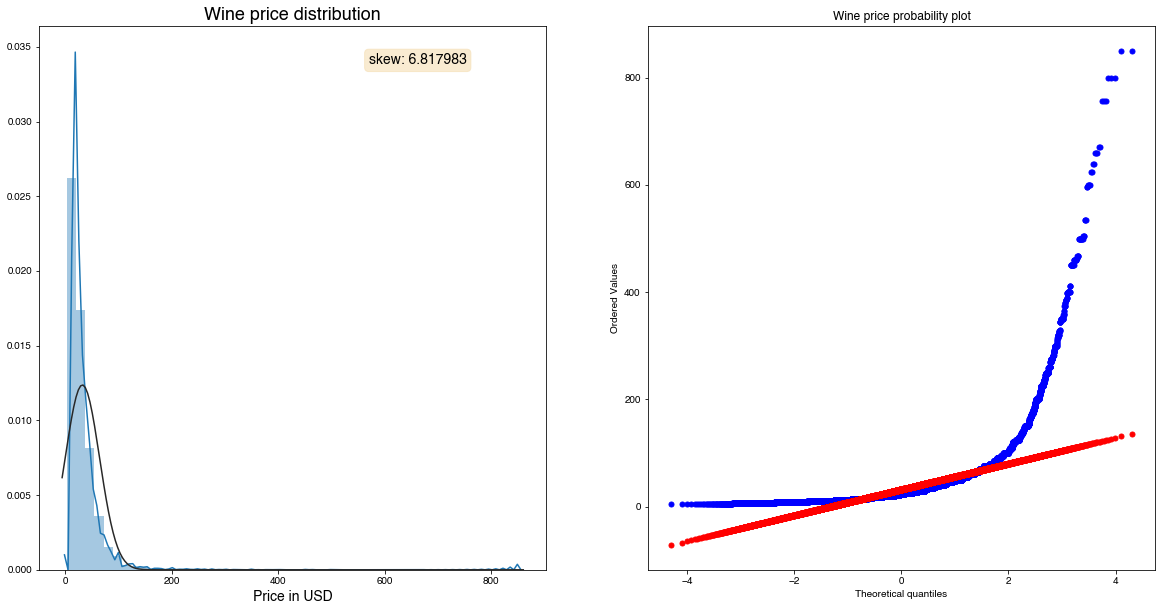

NormaltestResult(statistic=106103.49813080509, pvalue=0.0)


In [29]:
plt.figure(figsize=(20,10))

ax1 = plt.subplot(1,2,1)
sns.distplot(features['price'], ax=ax1, fit=norm)
ax1.set_xlabel('Price in USD', size=14)
ax1.set_title('Wine price distribution', size=18)
#text box
props = dict(boxstyle='round', color='wheat', alpha=.6)
textstr1 = 'skew: %f' % (features['price'].skew())
ax1.text(0.65, 0.95, textstr1, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax2 = plt.subplot(1,2,2)
stats.probplot(features['price'], plot=ax2)
ax2.set_title('Wine price probability plot')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_markerfacecolor('blue')
ax2.get_lines()[0].set_markersize(10)
ax2.get_lines()[1].set_linewidth(0)
ax2.get_lines()[1].set_marker('.')
ax2.get_lines()[1].set_markerfacecolor('red')
ax2.get_lines()[1].set_markersize(10)

plt.show()
print(stats.normaltest(a=features['price']))



- `price` is heavily skewed and needs to be transformed prior to modeling, to make the relationship between variables more linear
- We will log transform the data and create a new target variable, `logprice`

Visualizing our first regression target, `logprice`:

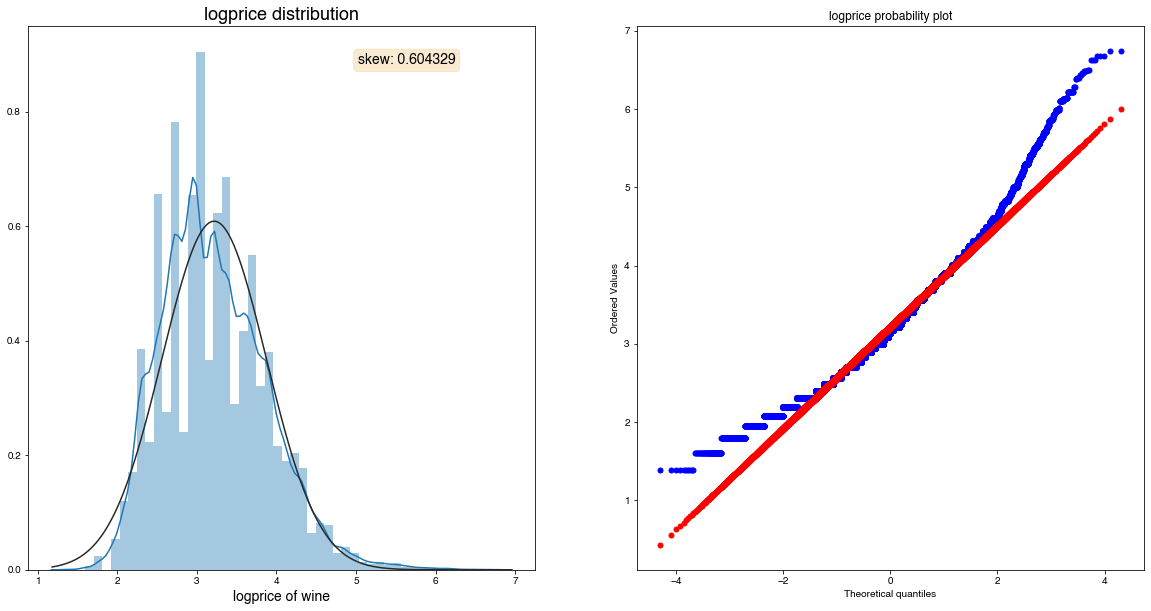

In [38]:
features['logprice'] = np.log(features['price'])

plt.figure(figsize=(20,10))

ax1 = plt.subplot(1,2,1)
sns.distplot(features['logprice'], ax=ax1, fit=norm)
ax1.set_xlabel('logprice of wine', size=14)
ax1.set_title('logprice distribution', size=18)
#text box
props = dict(boxstyle='round', color='wheat', alpha=.6)
textstr1 = 'skew: %f' % (features['logprice'].skew())
ax1.text(0.65, 0.95, textstr1, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax2 = plt.subplot(1,2,2)
stats.probplot(features['logprice'], plot=ax2)
ax2.set_title('logprice probability plot')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_markerfacecolor('blue')
ax2.get_lines()[0].set_markersize(10)
ax2.get_lines()[1].set_linewidth(0)
ax2.get_lines()[1].set_marker('.')
ax2.get_lines()[1].set_markerfacecolor('red')
ax2.get_lines()[1].set_markersize(10)

plt.show()



- Log transforming wine price results in a much more normal distribution

### Price Regression (as logprice):

The first outcome of interest for this dataset is price. A predictive model of a wine's price based on information found on the bottle (origin, variety, and description) as well as the points rating could be useful both to wine sellers and to consumers. Wineries and retailers could use such a model to help set the price point at which to sell their wine, and customers would likely find an estimation of price based on these variables useful to avoid overpaying.

#### Helper functions to model our data and plot our results:

In [5]:
# Instantialize Standard Scaler:
# Note: Because in linear regression the value of the coefficients is partially determined by the scale of the 
# feature, and in regularized models all coefficients are summed together, we must make sure to standardize
# the feature prior to training.
scaler = StandardScaler()

#regression modeling function:
def regression(model_name, target):
    
    # Creating training and testing sets to model and test on:
    if target == 'logprice':
      X = features2.drop(['price'], 1)
      scaler.fit_transform(X)
      Y = features['logprice']
      X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    elif target == 'points':
      X = features2.drop(['price', 'points'], 1)
      scaler.fit_transform(X)
      Y = features['points']
      X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
     
    start_time = time.clock()

    # Models to try:
    
    if model_name == 'OLS':
        model = linear_model.LinearRegression().fit(X_train, Y_train)
        
        #predictions:
        y_preds_train = model.predict(X_train)
        y_preds_test = model.predict(X_test)
   
    elif model_name == 'LASSO':
        alphas = [0.0001, 0.001, 0.01, 0.1 , 1, 10]

        model = LassoCV(alphas=alphas, cv=5)
        model.fit(X_train, Y_train)
        print("Best alpha value is: {}".format(model.alpha_))
        
        #predictions:
        y_preds_train = model.predict(X_train)
        y_preds_test = model.predict(X_test)
        
  
    elif model_name == 'Ridge':
        alphas = [0.0001, 0.001, 0.01, 0.1 , 1, 10]

        model = RidgeCV(alphas=alphas, cv=5)
        model.fit(X_train, Y_train)
        
        #predictions:
        y_preds_train = model.predict(X_train)
        y_preds_test = model.predict(X_test)
        print("Best alpha value is: {}".format(model.alpha_))
    
    elif model_name == 'Random Forest':
        model = ensemble.RandomForestRegressor(n_estimators=20).fit(X_train, Y_train)

        #Predictions:
        y_preds_train = model.predict(X_train)
        y_preds_test = model.predict(X_test)
    
    elif model_name == 'XGBoost':
        model = XGBRegressor().fit(X_train, Y_train)
        
        #Predictions:
        y_preds_train = model.predict(X_train)
        y_preds_test = model.predict(X_test)

    if target == 'points':
        #predictions rounded, as points are all integers:
        y_preds_train = [round(y) for y in y_preds_train]
        y_preds_test = [round(y) for y in y_preds_test]
        
        
    # Display Results:
    print("Model: {}".format(model_name))

    print("R-squared of the model in training set is: {}".format(model.score(X_train, Y_train)))
    print("-----Test set statistics-----")
    print("R-squared of the model in test set is: {}".format(model.score(X_test, Y_test)))
    print("Root mean squared error of the prediction is: {}".format(np.sqrt(mean_squared_error(Y_test, y_preds_test))))

    print("{} Regression Total runtime: {} seconds".format(model_name, round((time.clock()-start_time),2)))
    
    return model, X, Y

def plot_regression(model, X, Y):
    
    predicted = model.predict(X)
    actual = Y.values

    residual = actual - predicted

    plt.figure(figsize=(30,10))

    plt.subplot(1, 3, 1)
    plt.hist(residual, bins='auto')
    plt.title('Residual counts', fontsize=25)
    plt.xlabel('Residual', fontsize=15)
    plt.ylabel('Count', fontsize=15)

    plt.subplot(1, 3, 2)
    plt.scatter(predicted, residual, alpha=0.5) 
    plt.title('Residual vs. Predicted', fontsize=25)
    plt.xlabel('Predicted', fontsize=15)
    plt.ylabel('Residual', fontsize=15)
    plt.axhline(y=0, color='red')
    
    plt.subplot(1, 3, 3)
    sns.regplot(predicted, actual, line_kws={'color':'red'})
    plt.title('Predicted vs Actual', fontsize=25)
    plt.xlabel('Predicted', fontsize=15)
    plt.ylabel('Actual', fontsize=15)
    plt.legend(['R-coefficient: '+str(model.score(X, Y))[:5]])

    plt.show()
    return


#### Ordinary Least Squares:

In [0]:
model, X, Y = regression('OLS', 'logprice')


Model: OLS
R-squared of the model in training set is: 0.6454304256596026
-----Test set statistics-----
R-squared of the model in test set is: 0.6337740098468788
Root mean squared error of the prediction is: 0.39591867625262495
OLS Regression Total runtime: 44.32 seconds


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


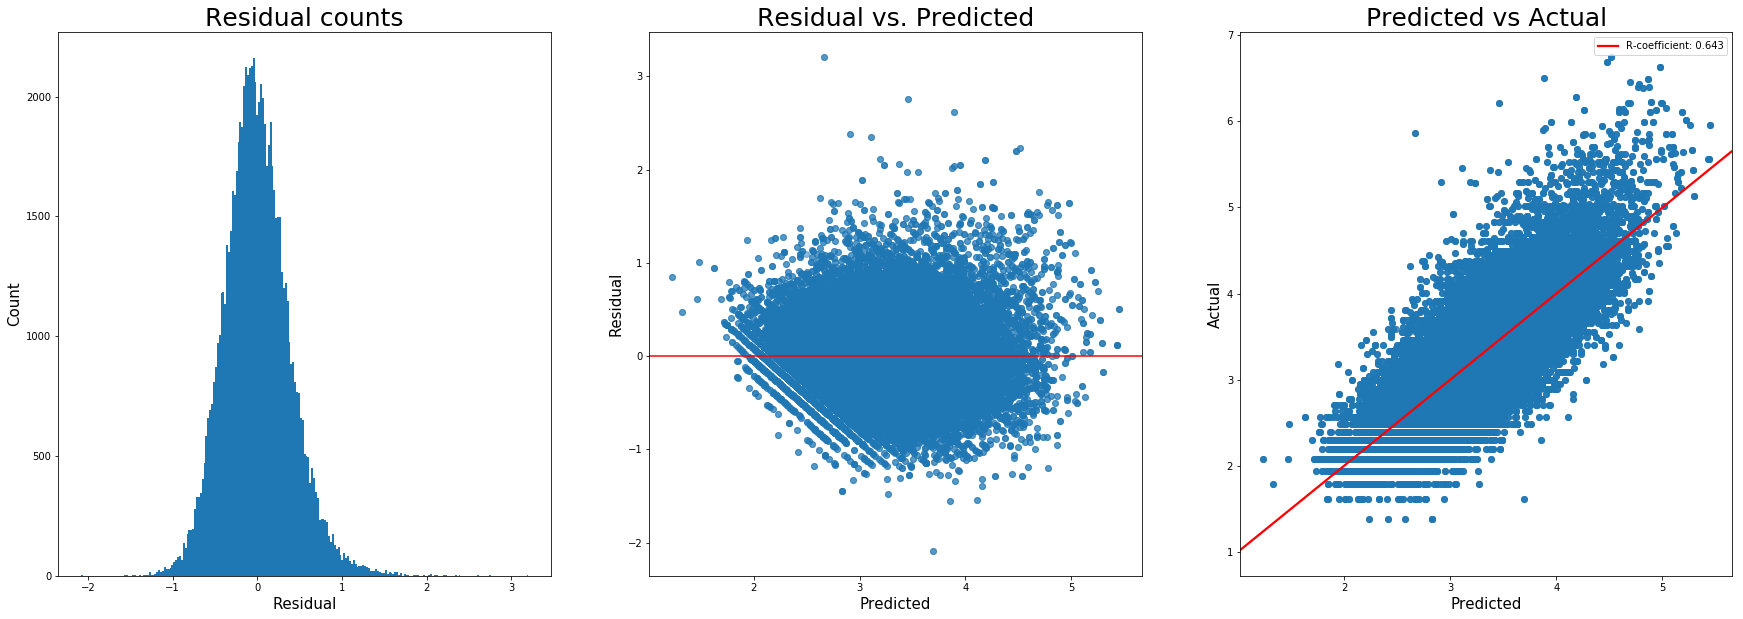

In [0]:
plot_regression(model, X, Y)

#### LASSO L1 Linear Regression:

In [0]:
model, X, Y = regression('LASSO', 'logprice')

Best alpha value is: 0.0001
Model: LASSO
R-squared of the model in training set is: 0.6117231605358859
-----Test set statistics-----
R-squared of the model in test set is: 0.6107204778058165
Root mean squared error of the prediction is: 0.4081898365424524
LASSO Regression Total runtime: 81.63 seconds


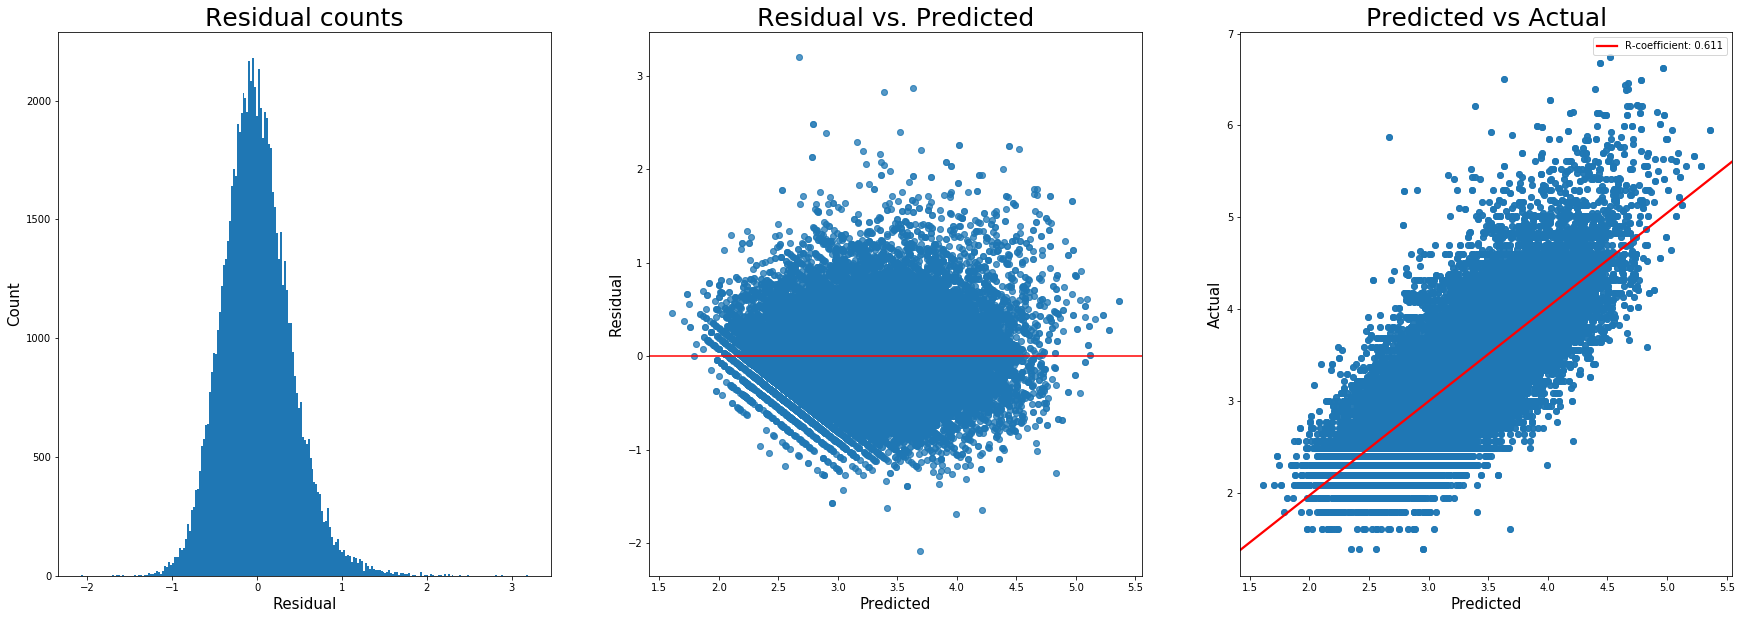

In [0]:
plot_regression(model, X, Y)

#### Ridge L2 Linear Regression:

In [0]:
model, X, Y = regression('Ridge', 'logprice')

Best alpha value is: 1.0
Model: Ridge
R-squared of the model in training set is: 0.645323996443379
-----Test set statistics-----
R-squared of the model in test set is: 0.6343438854333265
Root mean squared error of the prediction is: 0.3956105164900309
Ridge Regression Total runtime: 354.19 seconds


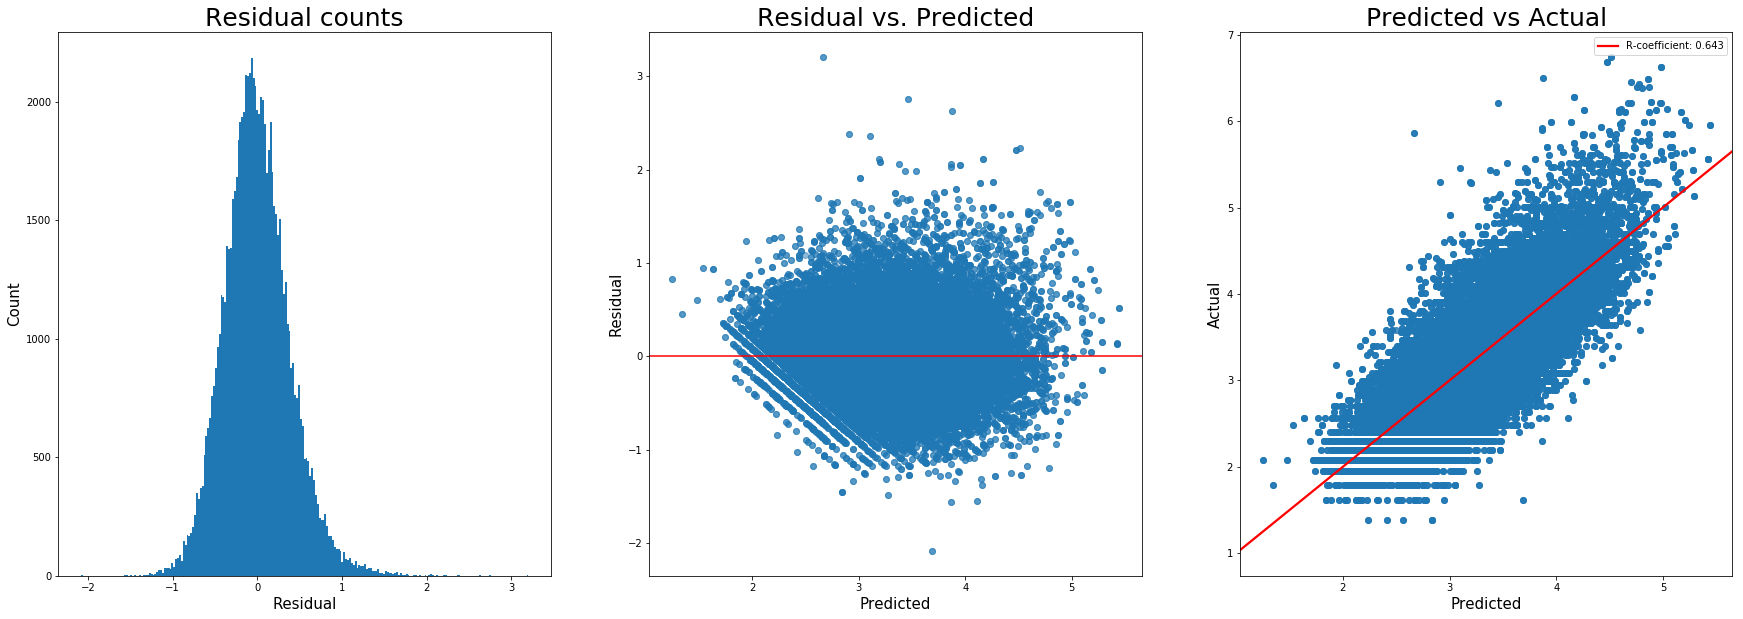

In [0]:
plot_regression(model, X, Y)

#### Random Forest Regression:

In [0]:
# This model was run with a previously written function similar to the one above, with default random forest
# hyper parameters, n_estimators=10
model, X, Y = logprice_regression('Random Forest')

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********************************
Random Forest Regression Training score: 0.9771757582238518
Random Forest Regression Test score: 0.882685862335381
Random Forest Regression Root Mean Squared Error: 0.22408179984457277
Random Forest Regression Total runtime: 1232.58 seconds


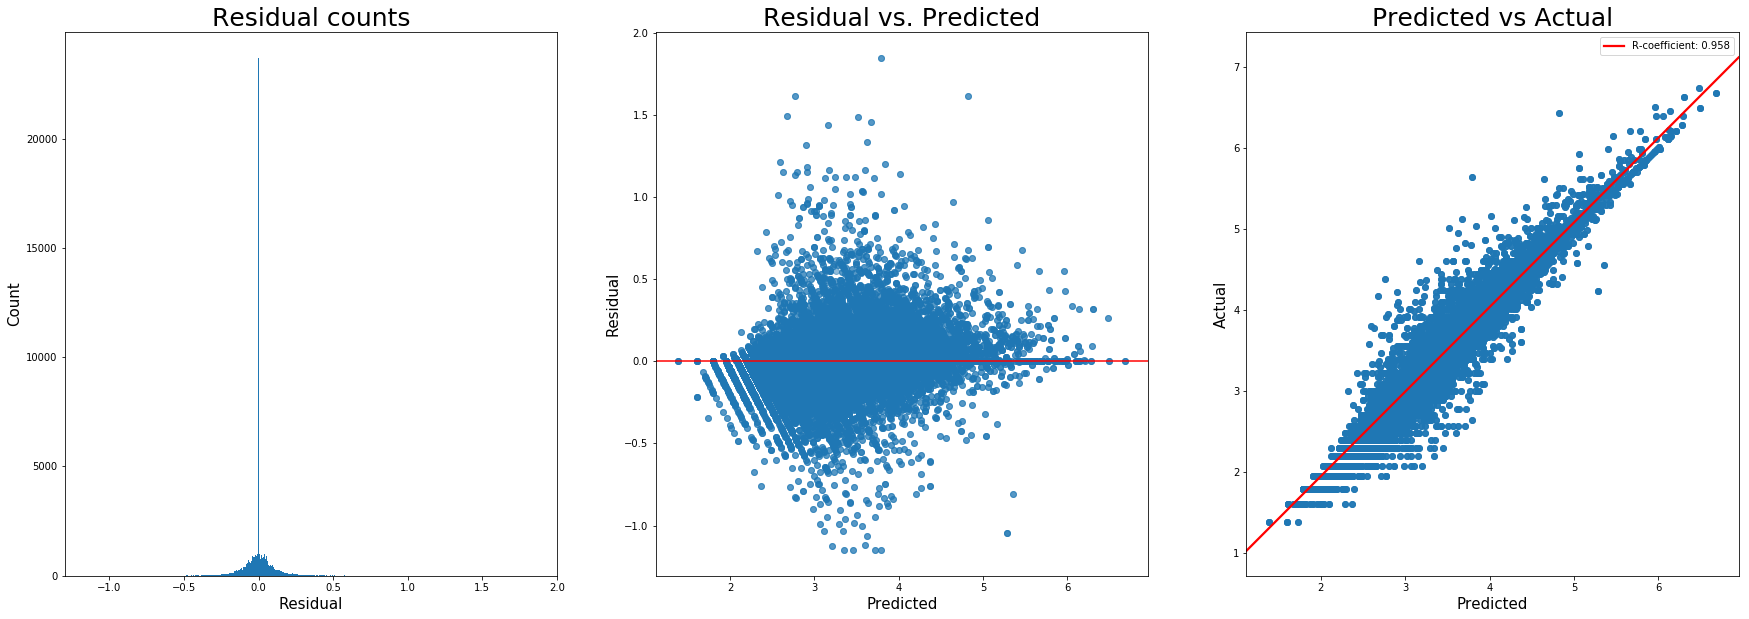

In [0]:
plot_logprice_regression(model, X, Y)

In [0]:
#n_estimators = 100
model, X, Y = regression('Random Forest', 'logprice')

Model: Random Forest
R-squared of the model in training set is: 0.987134805425895
-----Test set statistics-----
R-squared of the model in test set is: 0.9053025379768032
Root mean squared error of the prediction is: 0.2013263303940347
Random Forest Regression Total runtime: 11256.34 seconds


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


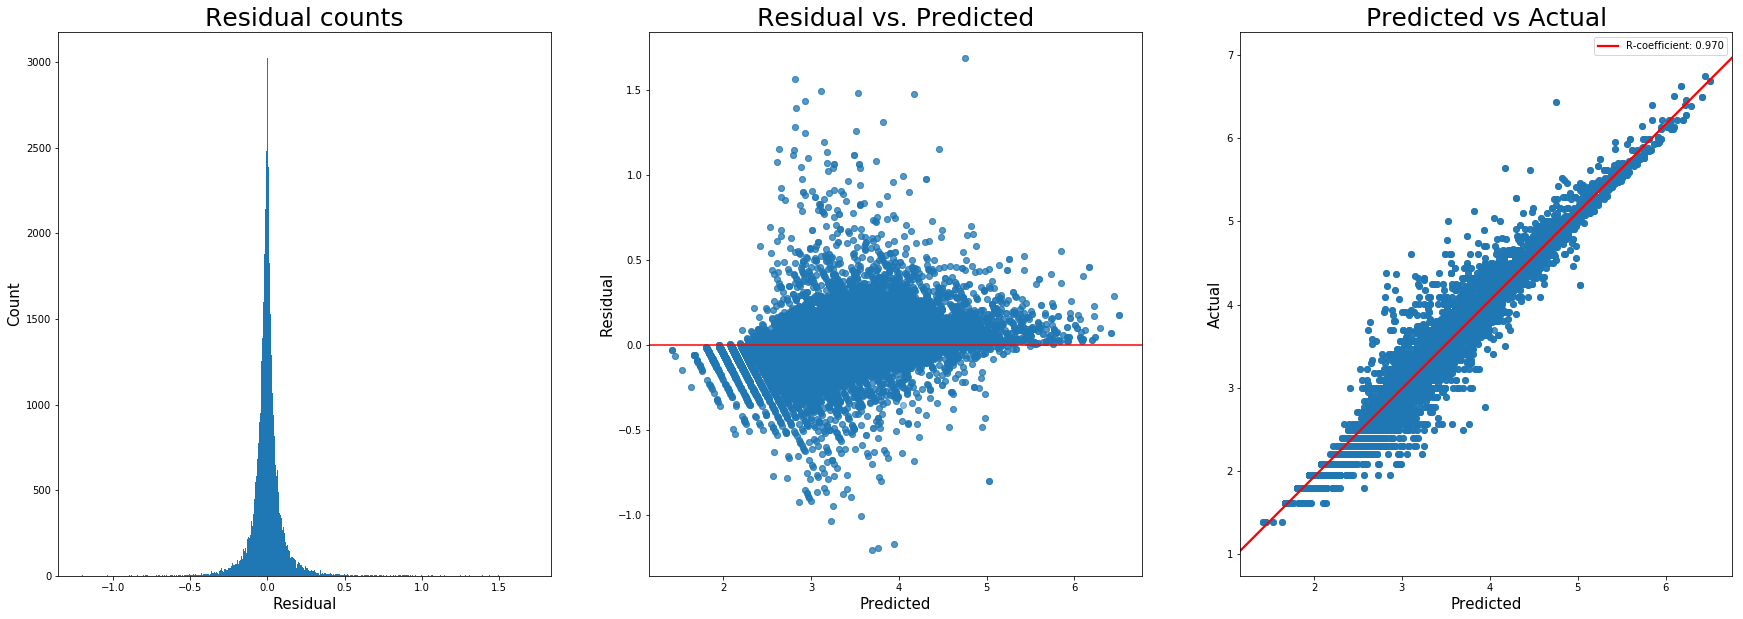

In [0]:
plot_regression(model, X, Y)

#### XGBoost Regression

In [11]:
model, X, Y = regression("XGBoost", 'logprice')

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[02:06:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBoost
R-squared of the model in training set is: 0.6171998873278086
-----Test set statistics-----
R-squared of the model in test set is: 0.6090637205385998
Root mean squared error of the prediction is: 0.40905753368673875
XGBoost Regression Total runtime: 665.15 seconds


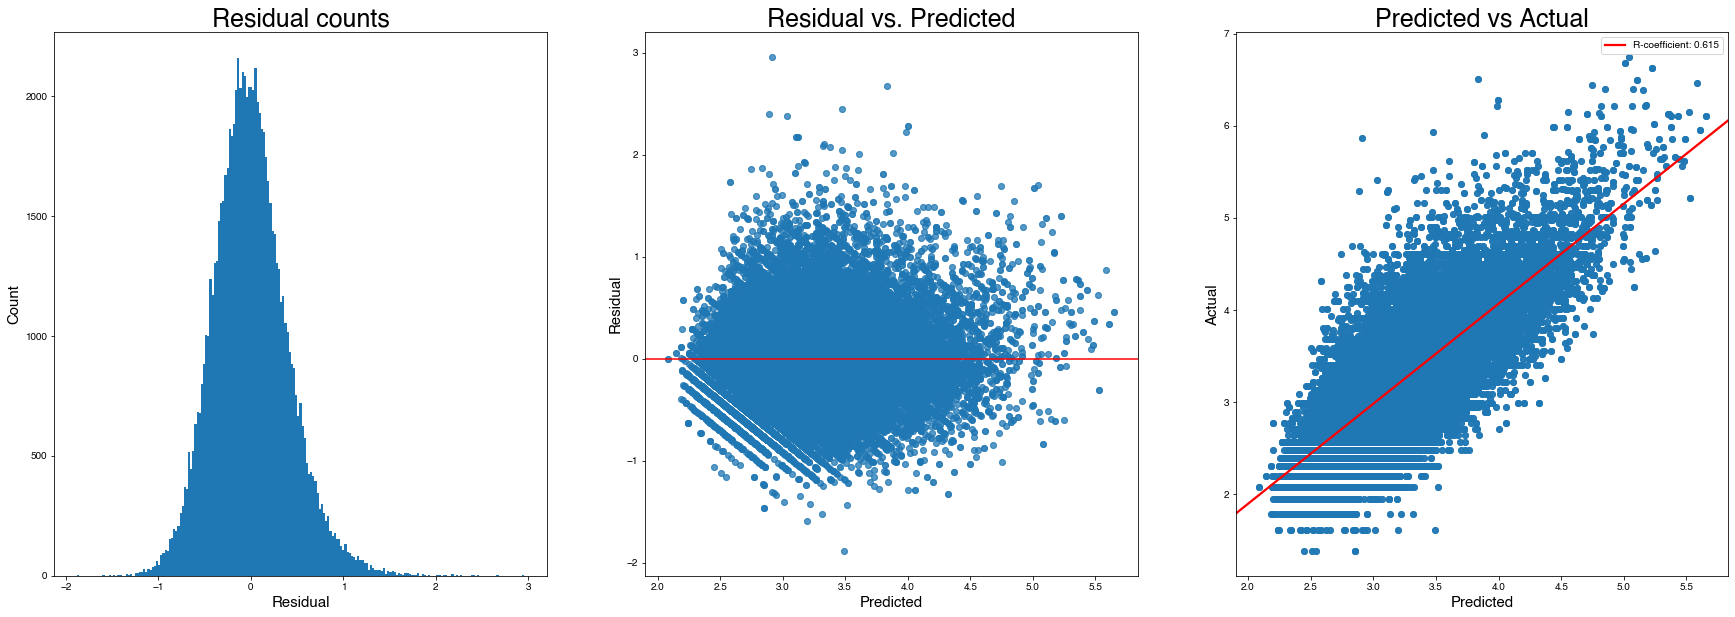

In [12]:
plot_regression(model, X, Y)

### Price (logprice) Regression results:

- Random Forest Regression outperformed all the other models, with good performance.
  - Highest R-squared (0.90)
  - Lowest Error  RMSE (0.20) 
    - This translates to an RMSE of +/- $1.22 per bottle of wine
  - Caveat: **Extremely** long runtime (11256.34 seconds), thats **3 HOURS**
 
  

## Points Regression: 
- Now we will try to predict the points rating of a wine, based only on review descriptions and origin information. We will not be using price, because the quality of a wine should be in its characteristics, not its price. The description length will be included as a feature to predict the points rating, however. 
- Point rating predictions were rounded to whole numbers, as all wine ratings are integer values

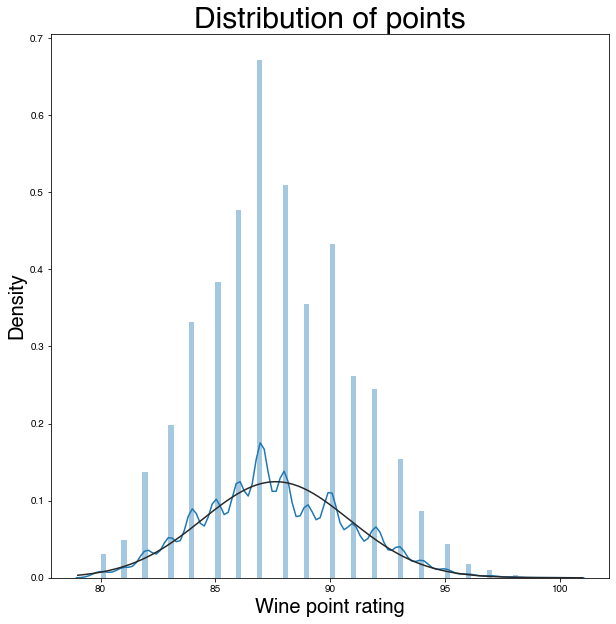

In [40]:
plt.figure(figsize=(10,10))
sns.distplot(features.points, fit=norm, bins='auto')
plt.title("Distribution of points", fontsize=30)
plt.xlabel("Wine point rating", fontsize=20)
plt.ylabel("Density", fontsize=20)
plt.show()


- Because `points` looks fairly normal in it's distribution, no transformation will be applied

#### OLS Regression:

In [0]:
model, X, Y = regression('OLS', 'points')

Model: OLS
R-squared of the model in training set is: 0.7390007500488321
-----Test set statistics-----
R-squared of the model in test set is: 0.7260402707032357
Root mean squared error of the prediction is: 1.6989799436394633
OLS Regression Total runtime: 39.28 seconds


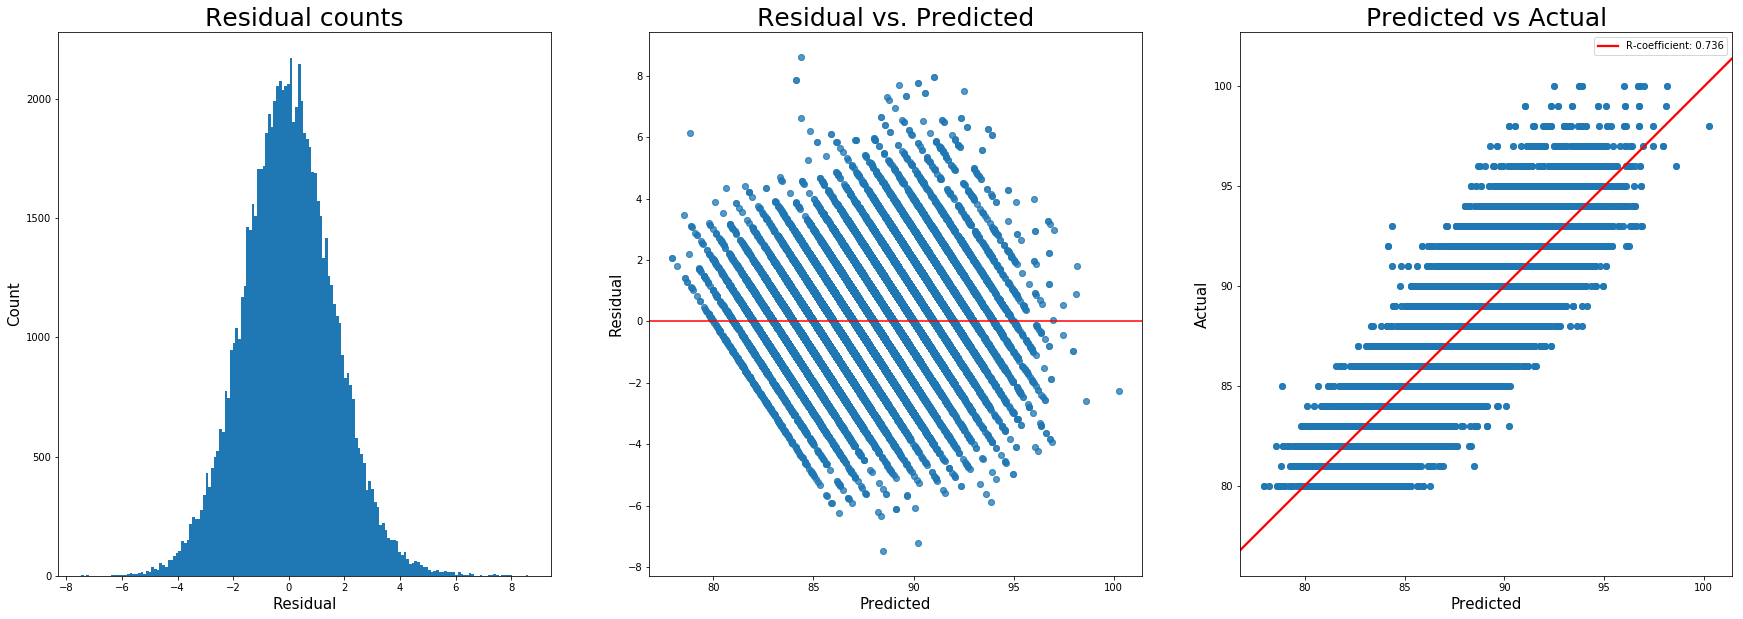

In [0]:
plot_regression(model, X, Y)

#### LASSO L1 Regression (Points):

In [0]:
model, X, Y = regression('LASSO', 'points')

Best alpha value is: 0.0001
Model: LASSO
R-squared of the model in training set is: 0.7351781233348127
-----Test set statistics-----
R-squared of the model in test set is: 0.7237730282407322
Root mean squared error of the prediction is: 1.6826138543628737
LASSO Regression Total runtime: 94.09 seconds


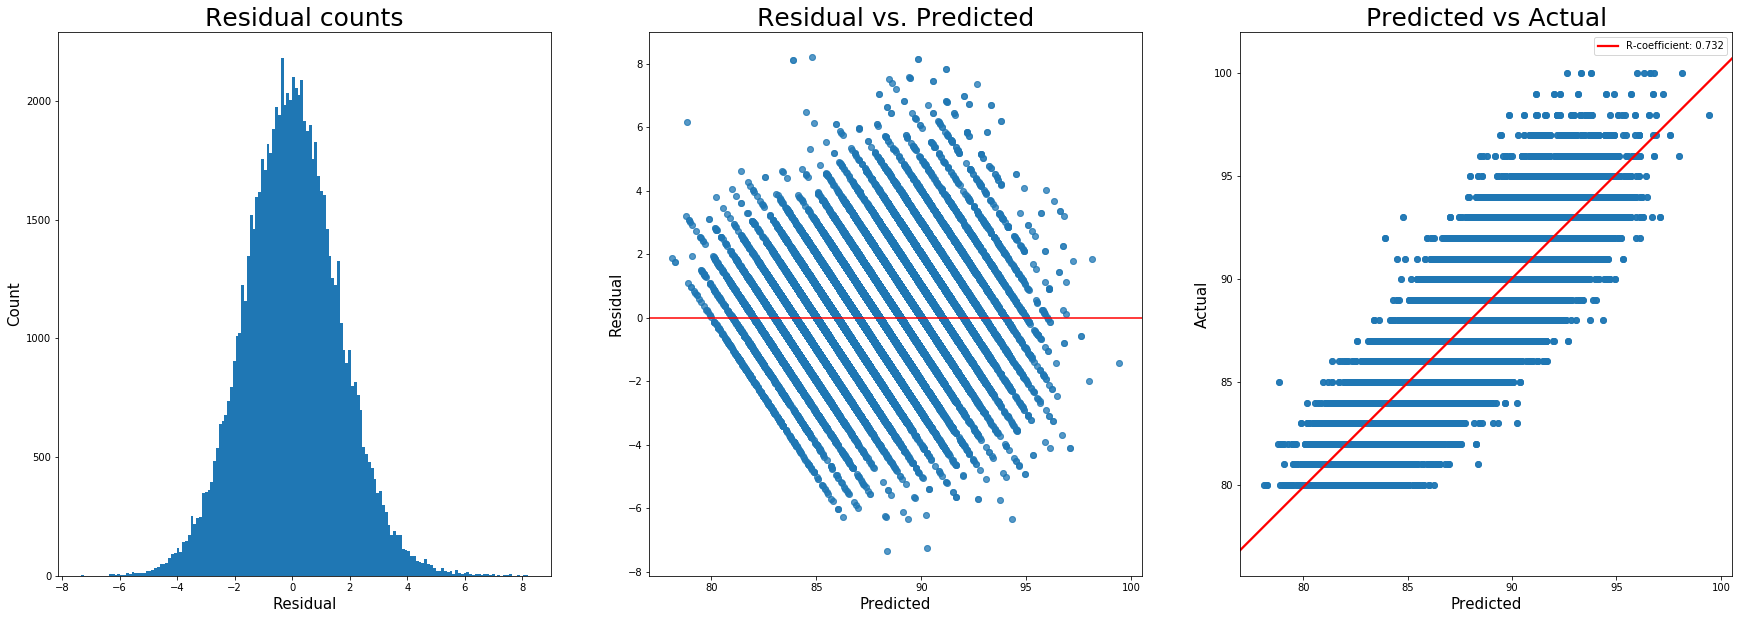

In [0]:
plot_regression(model, X, Y)

#### RIdge L2 Regression:

In [0]:
model, X, Y = regression('Ridge', 'points')

Best alpha value is: 1.0
Model: Ridge
R-squared of the model in training set is: 0.7388396669002422
-----Test set statistics-----
R-squared of the model in test set is: 0.726242476546801
Root mean squared error of the prediction is: 1.6750757485022691
Ridge Regression Total runtime: 358.07 seconds


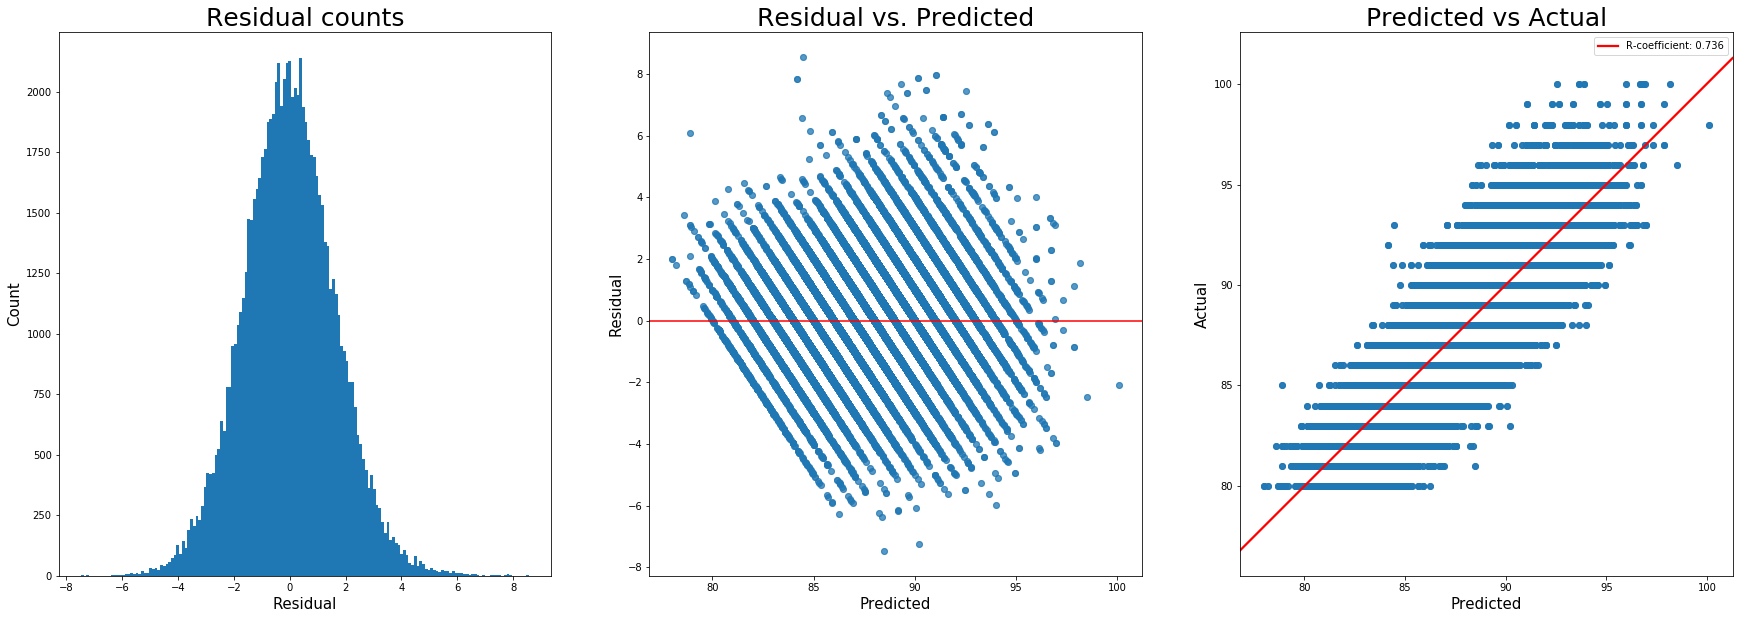

In [0]:
plot_regression(model, X, Y)

#### Random Forest Regression:

In [0]:
# This model was run with a previously written function similar to the one above, with default random forest
# hyper parameters, n_estimators=10
model, X, Y = points_regression('Random Forest')

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


********************************
Random Forest Regression Training score: 0.9758432788448189
Random Forest Regression Test score: 0.884558730446568
Random Forest Regression Root Mean Squared Error: 1.0877571995583588
Random Forest Regression Total runtime: 1017.97 seconds


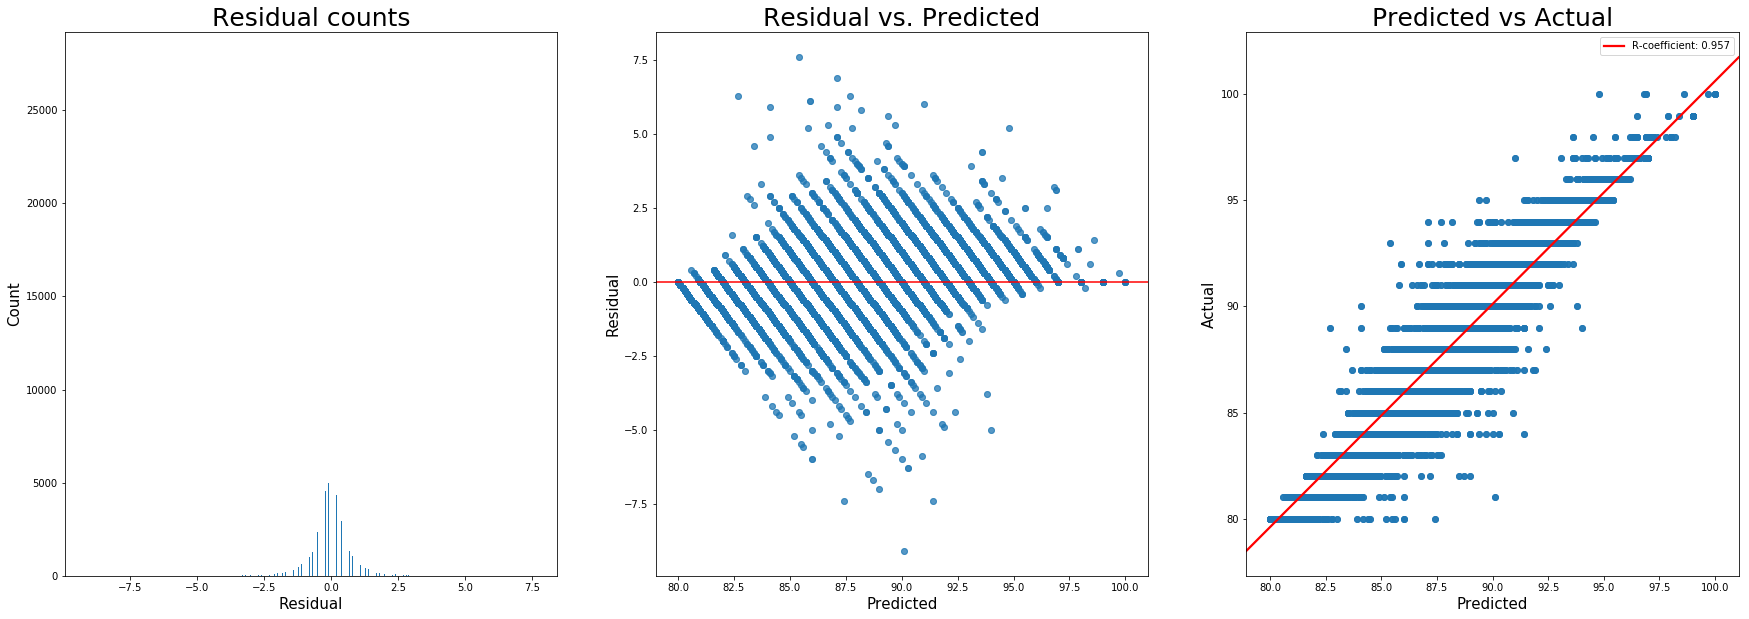

In [0]:
plot_points_regression(model, X, Y)

In [7]:
#  n_estimators = 20
model, X, Y = regression('Random Forest', 'points')


Model: Random Forest
R-squared of the model in training set is: 0.9820391706934485
-----Test set statistics-----
R-squared of the model in test set is: 0.8965005720696049
Root mean squared error of the prediction is: 1.0601651783998995
Random Forest Regression Total runtime: 1538.02 seconds


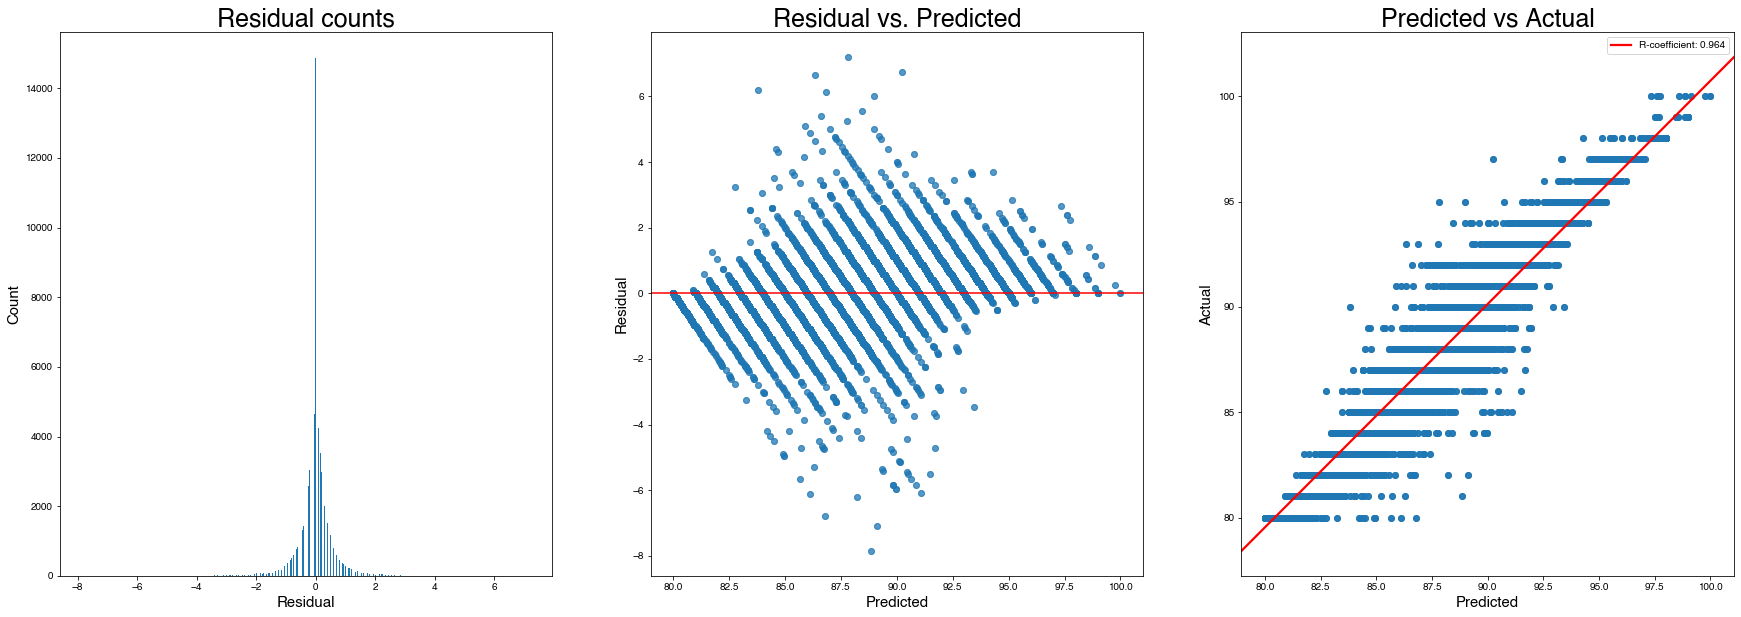

In [8]:
plot_regression(model, X, Y)

#### XGBoost Regression (Points):

In [9]:
model, X, Y = regression('XGBoost', 'points')

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:10:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBoost
R-squared of the model in training set is: 0.6451487995437091
-----Test set statistics-----
R-squared of the model in test set is: 0.6313938812533615
Root mean squared error of the prediction is: 1.962571936422877
XGBoost Regression Total runtime: 687.81 seconds


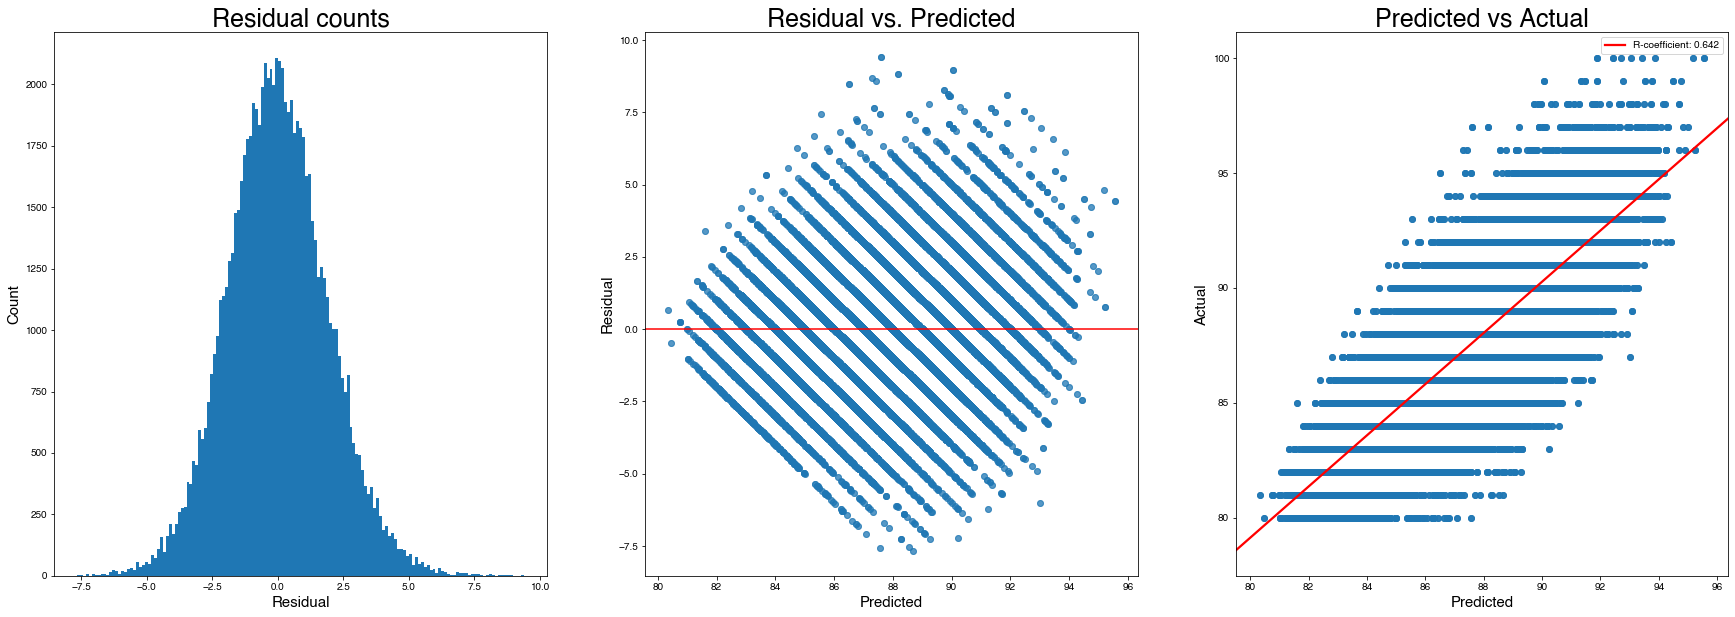

In [10]:
plot_regression(model, X, Y)

### Points Regression results:

- Random Forest Regression once again outperformed all the other models, with good performance.
  - Highest R-squared (0.896)
  - Lowest Error  RMSE (1.07) 
    - This translates to an RMSE of +/- 1.07 points in rating for wine, with no basis on the cost of the wine
  - Caveat: Of course, **Extremely** long runtime (1818.31 seconds)

# Conclusions:

## Results:
- For both price and point rating, random forest regressor models proved to be most accurate. 

- Models for predicting price and points yielded good R-Squared values, indicating a good ratio of explained variation in the dataset. Peak performing random forest models achieved R-Squared values of 0.905 for logprice and .896 for points. 
    - However, R-Squared is not the best measure of accuracy, as it only measures the strength of the relationship between the features and target variable
    
- To interpret the performance of the models, a greater emphasis was placed on the RMSE of the predictions.
    - RMSE measures the difference between predicted and actual values
    - Produces a non-negative value, where lower is better (0 indicates perfect fit)
    - Most importantly, is an absolute measure of fit (as opposed to R-Squared, which is relative)
    - Model RMSE results are readily interpretable
    
- Results of the regression were pretty good, with a baseline performance of predicting wine prices within USD 1.48 (RMSE = 0.396), and peak performance of predicting prices within USD 1.22 (RMSE =  is: 0.201). These predictions were based on the point ratings of the wines, description length, and information derived from the descriptions of the wines written by sommeliers as well as the origins of the wines.

- For predicting point ratings of wines, prices were disregarded and only information from the description and origin was used. Results were once again pretty good, with baseline point predictions were within 1.69 points of the actual rating, with peak performance of predictions within 1.06 points. 

## Caveats and Obstacles: 
- The "points" ratings in this set are all between 80 and 100 points, so our models are only tailored to predict generally "good" wines. 

- In addition the ratings are all subjective, as are the individual descriptions by the sommeliers.


- Due to the size of the featureset used to predict prices and point ratings, models took very long to run. Even after a 50% dimensionality reduction of the TF-IDF sparse matrix and 82% dimensionality reduction of the wine origin categorical data, the entire featureset was still very large (13603 x 83942, 1.0 GB memory usage). 

- Random Forests, the best performing models, took extremely long to fit and predict on training and test data. Due to this, comprehensive hyperparameter tuning was not a viable option, as running the model iteratively with different hyperparameters would take far too long. For this reason, Support Vector Machine and K-Nearest Neighbors regression models were not attempted as their runtimes would have been similar. 
    - Random Forests were run with a couple hyperparameters, specifically looking at number of estimators (number of descision trees used in the forest models). Models were initially ran with 10 estimators, and a 100 estimator model was tried on logprice, resulting in a slight increase in performance with respect to RMSE, but 10-fold increase in runtime. 

 
## Future Thoughts:
- Further refinement of this modeling dataset could be merging it with geographical weather datasets, to predict the best climates for wines to grow.

- The same data pipelining method could be applied to user-submitted information for other beverages, such as beer. RateBeer, BeerAdvocate, and Untappd are all beer review websites, with ratings for beers. 

